# Appendix 10.4.4: Best practices for using vision with Claude

Vision allows for a new mode of interaction with Claude. We’ve compiled a few tips for getting the best performance on your images. Before we get to that, let's first setup the code we need to run the notebook.

In [ ]:
%pip install -qUr requirements.txt

In [1]:
import boto3
from IPython.display import Image
from botocore.exceptions import ClientError
import base64
import io
import os
from PIL import Image as PILImage

session = boto3.Session()
region = session.region_name

modelId = 'anthropic.claude-3-5-sonnet-20241022-v2:0'

print(f'Using modelId: {modelId}')
print('Using region: ', region)

bedrock_client = boto3.client(service_name = 'bedrock-runtime', region_name = region,)


Using modelId: anthropic.claude-3-5-sonnet-20241022-v2:0
Using region:  us-west-2


## Applying traditional techniques to multimodal

You can fix hallucination issues with traditional prompt engineering techniques like role assignment. Let’s see an example of this:


Suppose I want Claude to count the number of dogs in this image:

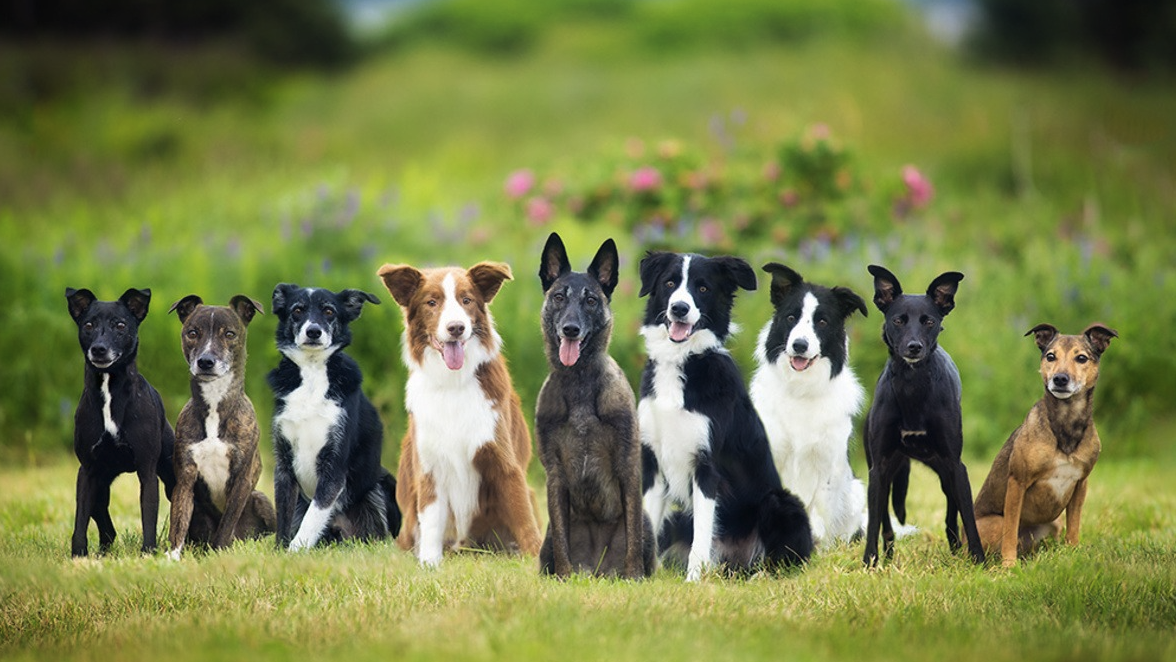

In [2]:
# Let's also see the image for ourself
Image(filename='./images/best_practices/nine_dogs.png') 

In [3]:
with open("./images/best_practices/nine_dogs.png", "rb") as f:
    image_file = f.read()

In [4]:
messages = [
    {
        "role": 'user',
        "content": [
            {"text": "How many dogs are in this photo?"},
            {"image": {
                "format": 'png',
                "source": {"bytes": image_file}
                },
            }
        ]
    }
]

converse_api_params = {
    "modelId": modelId,
    "messages": messages,
}

response = bedrock_client.converse(**converse_api_params)
# Extract the generated text content from the response
print(response['output']['message']['content'][0]['text'])

In this photo, there are 9 dogs lined up together. They appear to be Border Collies and similar herding breeds, with various coat colors including black and white, brown and white, and solid black. They're all sitting attentively in a grassy field with flowers in the background.


There's only 9 dogs but Claude thinks there is 10! Let’s apply a little prompt engineering and and try again.

In [5]:
messages = [
    {
        "role": 'user',
        "content": [
            {"text": "You have perfect vision and pay great attention to detail which makes you an expert at counting objects in images. How many dogs are in this picture? Before providing the answer in <answer> tags, think step by step in <thinking> tags and analyze every part of the image."},
            {"image": {
                "format": 'png',
                "source": {"bytes": image_file }
                },
            }
        ]
    }
]


converse_api_params = {
    "modelId": modelId,
    "messages": messages,
}
response = bedrock_client.converse(**converse_api_params)

print(response['output']['message']['content'][0]['text'])

<thinking>
Let me count the dogs carefully from left to right:
1. Black dog with pointed ears
2. Brown/tan colored dog
3. Black and white dog
4. Black and brown dog
5. Brown and white dog (looks like a Border Collie)
6. Black dog
7. Black and white dog
8. Black and white dog
9. Black dog with pointed ears

Looking at the image again to make sure I haven't missed any dogs hidden behind others or in the background. All dogs appear to be sitting in a single line and are clearly visible. They appear to be Border Collies or similar herding breeds. The background is a green field with some flowers.
</thinking>

<answer>9 dogs</answer>


Great! After applying some prompt engineering to the prompt, we see that Claude now counts correctly that there is 9 dogs.

## Visual prompting 

Images as input allows for prompts to now be given within the image itself. Let’s take a look at some examples.

In this image, we write some text and draw an arrow on it. Let’s just pass this in to Claude with no accompanying text prompt.

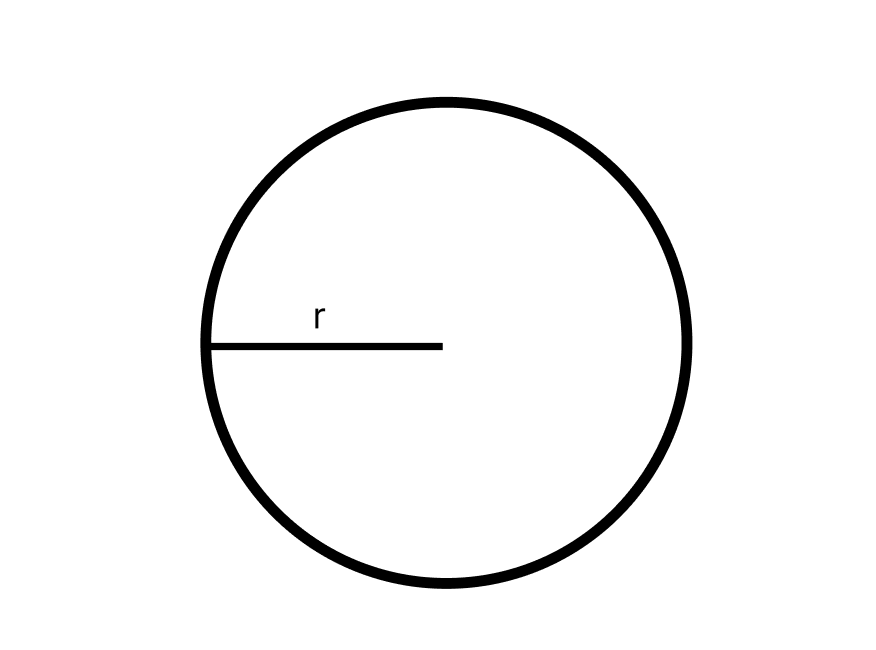

In [6]:
Image(filename='./images/best_practices/circle.png') 

In [7]:
with open("./images/best_practices/circle.png", "rb") as f:
    image_file = f.read()

messages = [
    {
        "role": 'user',
        "content": [
            {"image": {
                "format": 'png',
                "source": {"bytes": image_file}
                },
            }
        ]
    }
]

converse_api_params = {
    "modelId": modelId,
    "messages": messages,
    "inferenceConfig": {"maxTokens": 2048},
}
response = bedrock_client.converse(**converse_api_params)

print(response['output']['message']['content'][0]['text'])

This is a simple geometric diagram showing a circle with a radius (labeled as "r") drawn from the center to a point on the circle's circumference. The radius is represented by a straight line segment extending from the center point to the edge of the circle. This is a basic but fundamental diagram used in geometry to illustrate the concept of a circle's radius, which is the distance from the center point to any point on the circle's circumference.


As you can see, Claude tried to describe the image as we didn’t give it a question. Let’s add a question to the image and pass it in again.

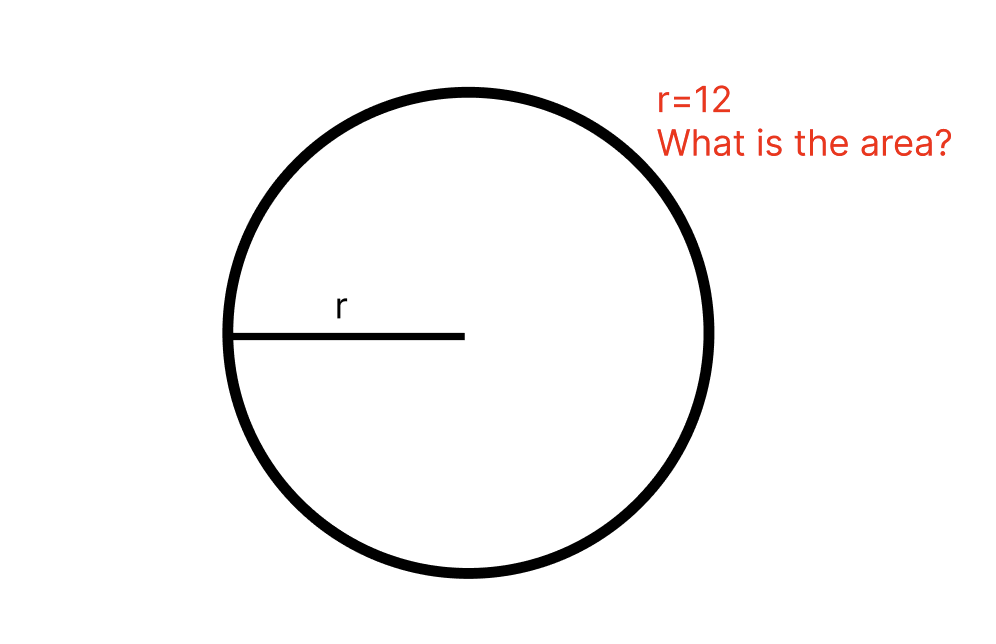

In [8]:
Image(filename='./images/best_practices/labeled_circle.png') 

In [9]:
with open("./images/best_practices/labeled_circle.png", "rb") as f:
    image_file = f.read()

messages = [
    {
        "role": 'user',
        "content": [
            {"image": {
                "format": 'png',
                "source": {"bytes": image_file}
                },
            }
        ]
    }
]


converse_api_params = {
    "modelId": modelId,
    "messages": messages,
    "inferenceConfig": {"maxTokens": 2048},
}
response = bedrock_client.converse(**converse_api_params)

print(response['output']['message']['content'][0]['text'])

To find the area of a circle, we use the formula A = πr², where r is the radius.

Given that r = 12:

A = π(12)²
A = π(144)
A = 452.39... square units (using π ≈ 3.14159)

Therefore, the area of the circle is approximately 452.4 square units.


We can also highlight specific parts of the image and ask questions about it.

What’s the difference between these two numbers?

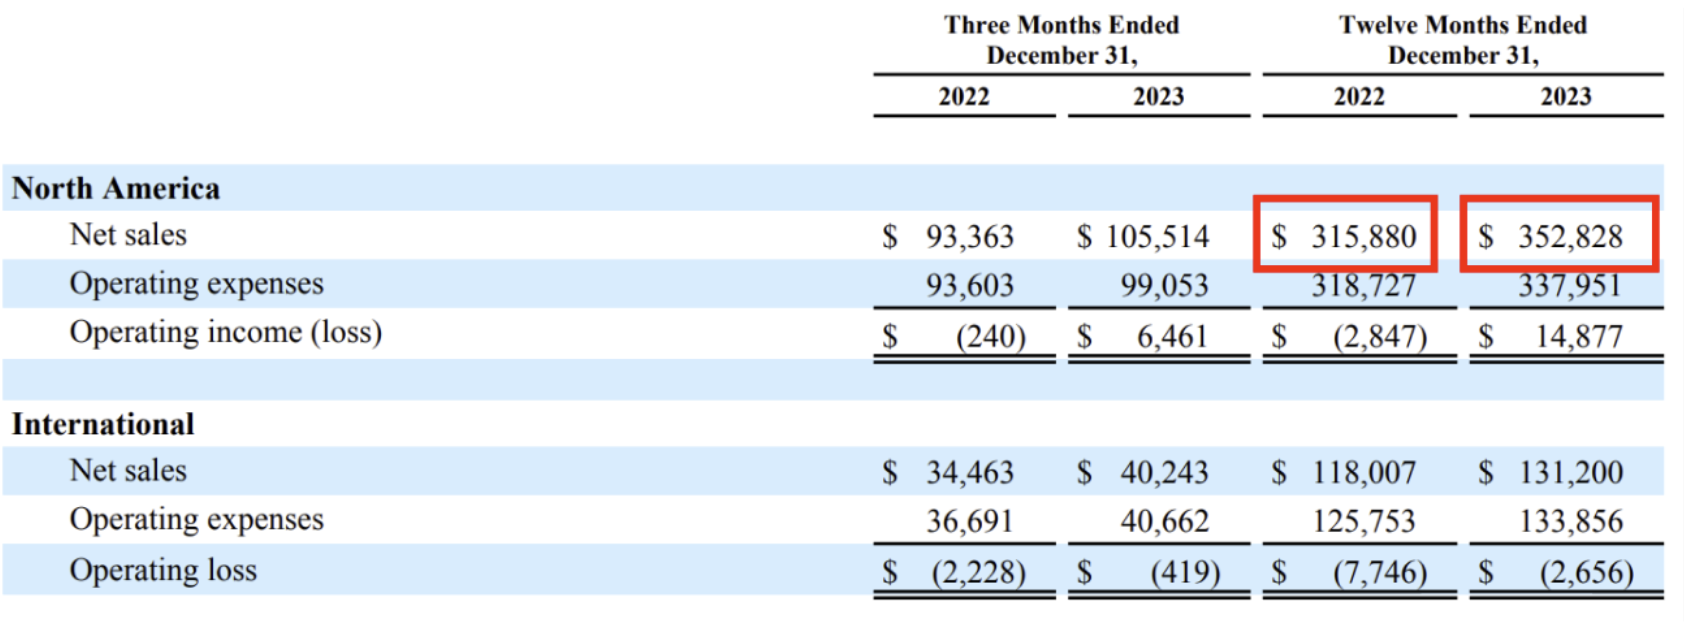

In [10]:
Image(filename='./images/best_practices/table.png') 

In [11]:
with open("./images/best_practices/table.png", "rb") as f:
    image_file = f.read()

In [12]:
messages = [
    {
        "role": 'user',
        "content": [
            {"image": {
                "format": 'png',
                "source": {"bytes": image_file}
                },
            },
            {"text": "What’s the difference between these two numbers?"},
        ]
    }
]

converse_api_params = {
    "modelId": modelId,
    "messages": messages,
}
response = bedrock_client.converse(**converse_api_params)

# Extract the generated text content from the response
print(response['output']['message']['content'][0]['text'])

Looking at the numbers highlighted in red boxes in the image, the difference between the North America net sales figures for:

$352,828 (2023) - $315,880 (2022) = $36,948

So the difference is $36,948, which represents the increase in net sales from 2022 to 2023 for the twelve months ended December 31.


## Few-shot examples

Adding examples to prompts still improves accuracy with visual tasks as well. Let’s ask Claude to read a picture of a speedometer. 

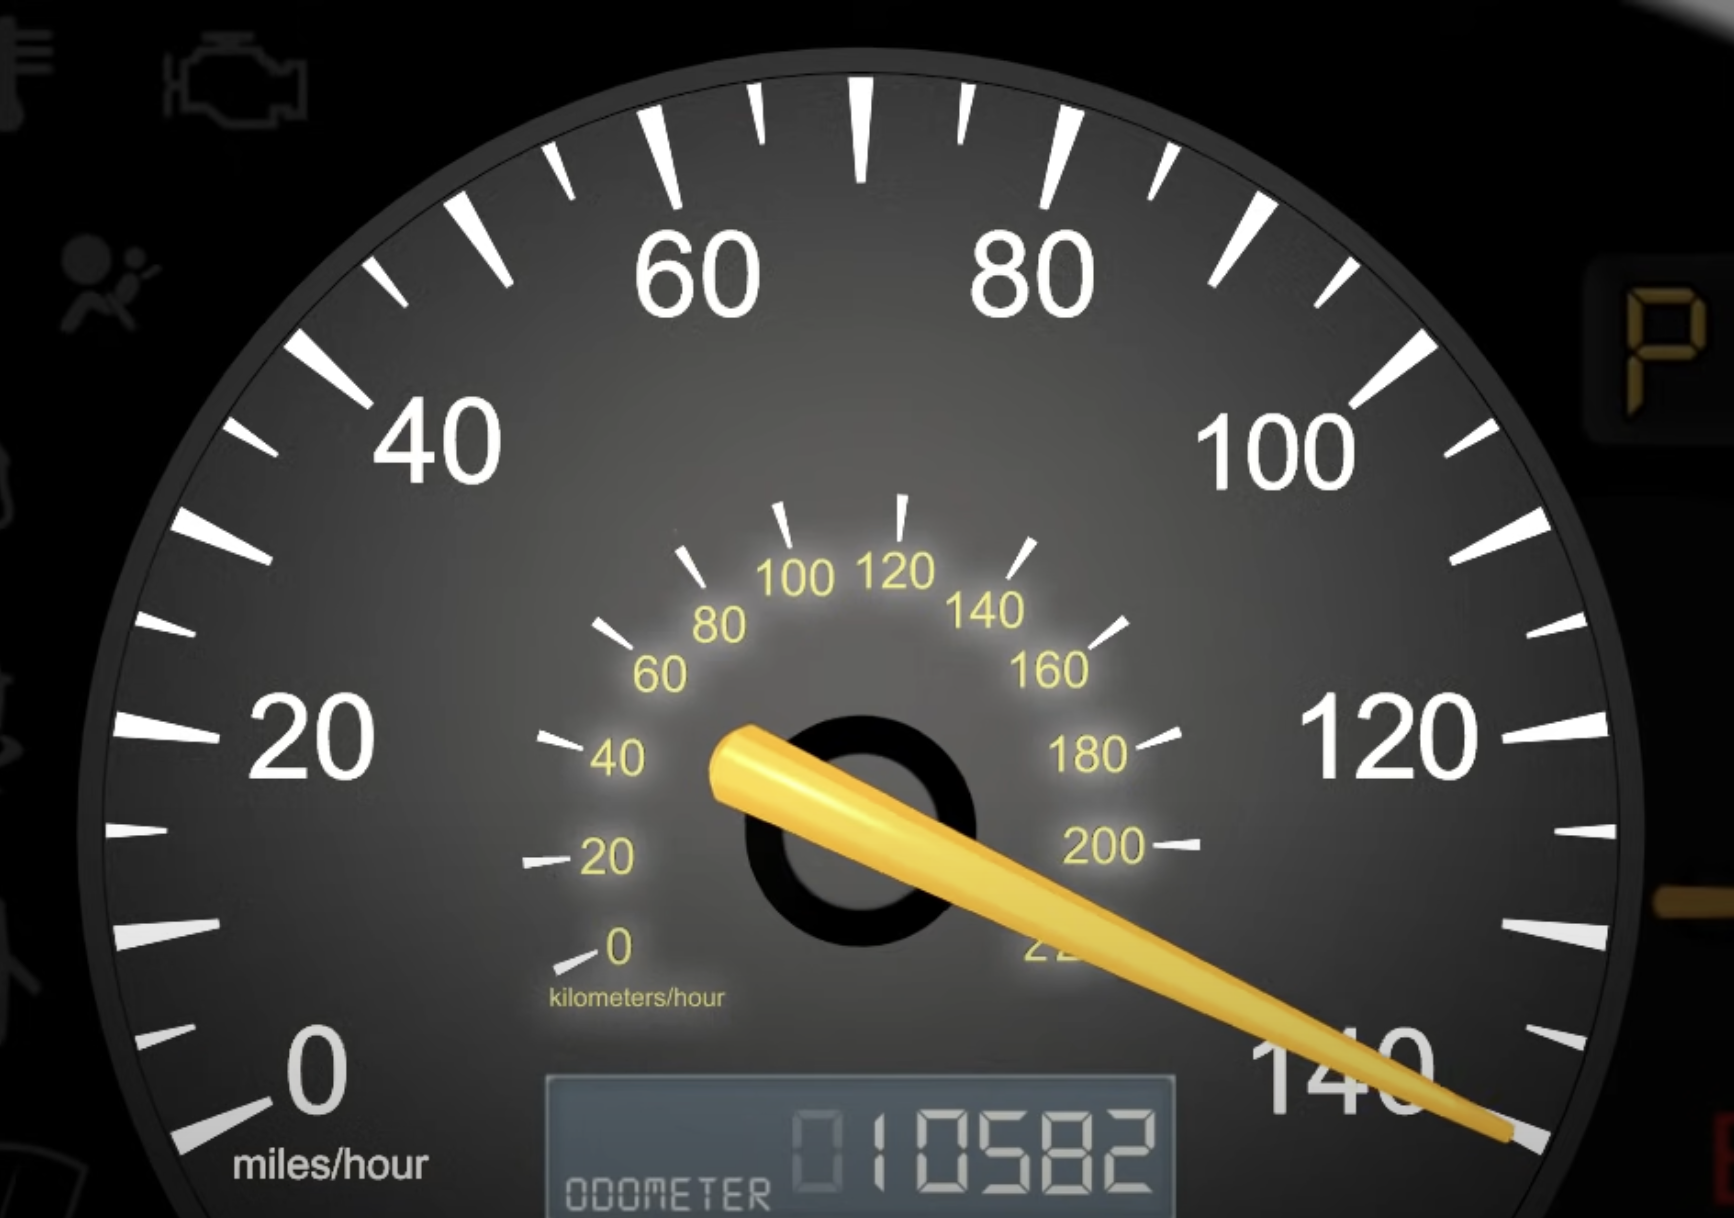

In [13]:
Image(filename='./images/best_practices/140.png')

In [14]:
with open("./images/best_practices/140.png", "rb") as f:
    image_file = f.read()

In [15]:
messages = [
    {
        "role": 'user',
        "content": [
            {"image": {
                "format": 'png',
                "source": {"bytes": image_file}
                },
            },
            {"text": "What speed am I going?"},
        ]
    }
]

converse_api_params = {
    "modelId": modelId,
    "messages": messages,
}
response = bedrock_client.converse(**converse_api_params)

# Extract the generated text content from the response
print(response['output']['message']['content'][0]['text'])

Based on the speedometer shown in the image, you are traveling at approximately 180 kilometers per hour (about 112 miles per hour). The speedometer shows both miles per hour (in white numbers) and kilometers per hour (in yellow numbers), and the yellow needle is pointing to around the 180 km/h mark. That's quite fast and above most speed limits - please make sure to drive safely and follow local traffic laws!


Claude’s answer doesn’t look quite right here, it thinks we are going 140km/hour and not 140 miles/hour! Let’s try again but this time let’s add some examples to the prompt.

In [16]:
with open("./images/best_practices/70.png", "rb") as f:
    image_file_70 = f.read()
    
with open("./images/best_practices/140.png", "rb") as f:
    image_file_100 = f.read()
    
with open("./images/best_practices/140.png", "rb") as f:
    image_file_140 = f.read()

In [17]:
messages = [
    {
        "role": 'user',
        "content": [
            {"image": {
                "format": 'png',
                "source": {"bytes": image_file_70}
                },
            },
            {"text": "Kilometers/hr are near the center in yellow, Miles per hours are around outer the edge in white. What speed am I going?"},
        ]
    },
    {
        "role": 'assistant',
        "content": [
            {"text": "You are going 70 miles per hour."}
        ]
    },
    {
        "role": 'user',
        "content": [
            {"image": {
                "format": 'png',
                "source": {"bytes": image_file_100}
                },
            },
            {"text": "Kilometers/hr are near the center in yellow, Miles per hours are around outer the edge in white. What speed am I going? What speed am I going?"},
        ]
    },
    {
        "role": 'assistant',
        "content": [
            {"text": "You are going 100 miles per hour."}
        ]
    },
    {
        "role": 'user',
        "content": [
            {"image": {
                "format": 'png',
                "source": {"bytes": image_file_140}
                },
            },
            {"text": "What speed am I going?"},
        ]
    },
]


converse_api_params = {
    "modelId": modelId,
    "messages": messages,
}
response = bedrock_client.converse(**converse_api_params)

# Extract the generated text content from the response
print(response['output']['message']['content'][0]['text'])

Looking at the speedometer, you are going approximately 100 miles per hour (or about 160 kilometers per hour, as shown on the inner yellow markings).


Perfect! With those examples, Claude learned how to read the speed on the speedometer. Note though that few-shot prompting with images doesn't always work but it is worth trying on your use case.

## Multiple images as input
Claude can also accept and reason over multiple images at once within the prompt as well! For example, let’s say you had a really large image - like an image of a long receipt! We can split that image up into chunks and feed each one of those chunks into Claude.

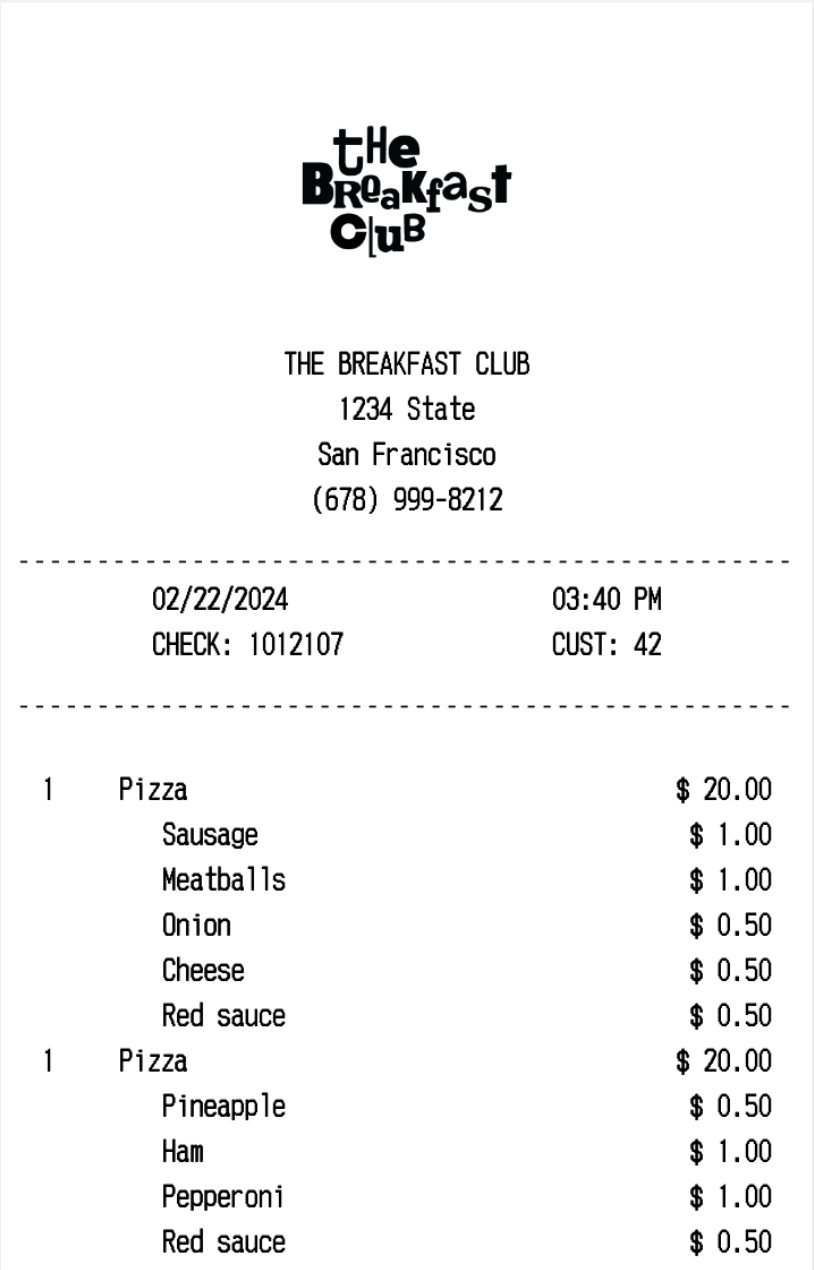

In [18]:
Image(filename='./images/best_practices/receipt1.png')

In [19]:
with open("./images/best_practices/receipt1.png", "rb") as f:
    receipt1 = f.read()

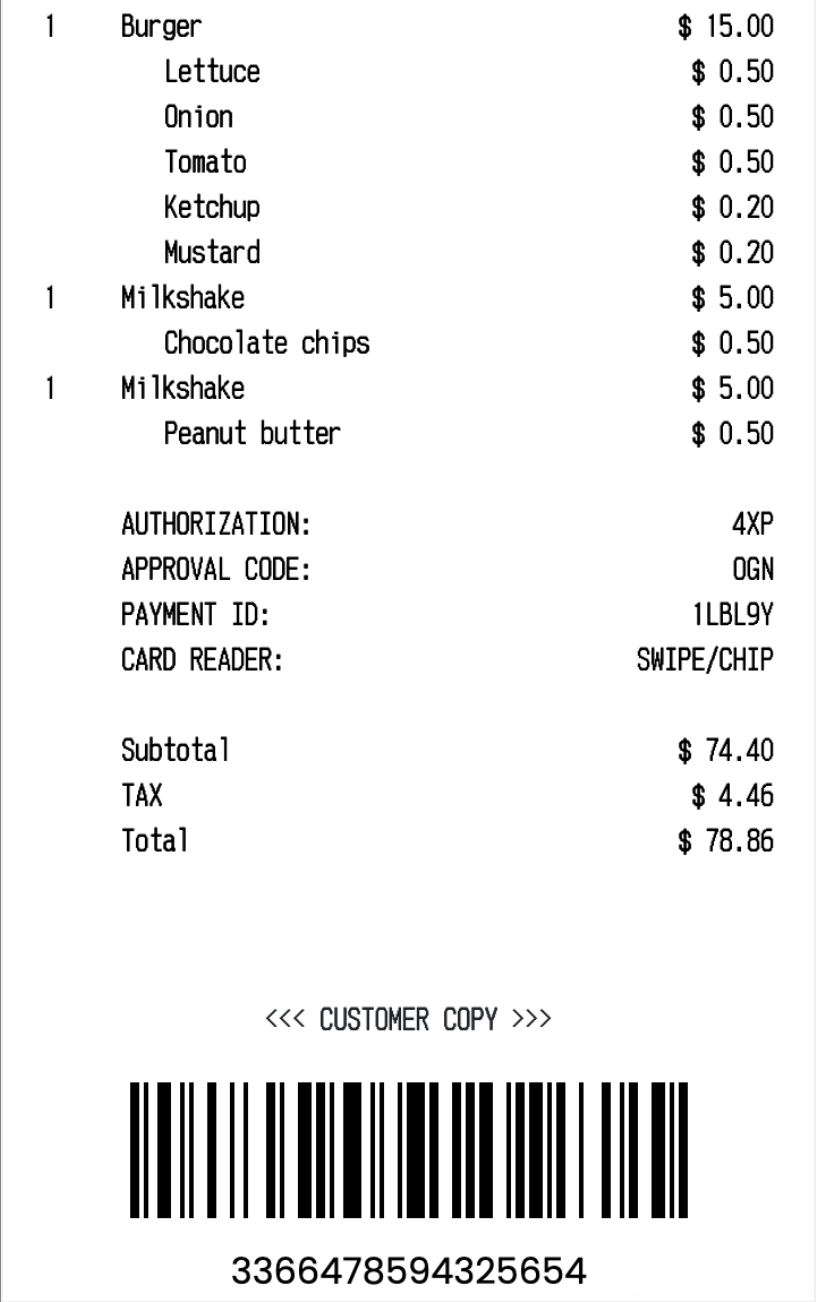

In [20]:
Image(filename='./images/best_practices/receipt2.png')

In [21]:
with open("./images/best_practices/receipt2.png", "rb") as f:
    receipt2 = f.read()

In [22]:
messages = [
    {
        "role": 'user',
        "content": [
            {"image": {"format": 'png',"source": {"bytes": receipt1}},},
            {"image": {"format": 'png',"source": {"bytes": receipt2}},},
            {"text": "Output the name of the restaurant and the total."},
        ]
    }
]

converse_api_params = {
    "modelId": modelId,
    "messages": messages,
}
response = bedrock_client.converse(**converse_api_params)

# Extract the generated text content from the response
print(response['output']['message']['content'][0]['text'])

Restaurant: The Breakfast Club
Total: $78.86


## Object identification from examples

With image input, you can pass in other images to the prompt and Claude will use that information to answer questions. Let’s see an example of this. 

Suppose we were trying to identify the type of pant in an image. We can provide Claude some examples of different types of pants in the prompt.

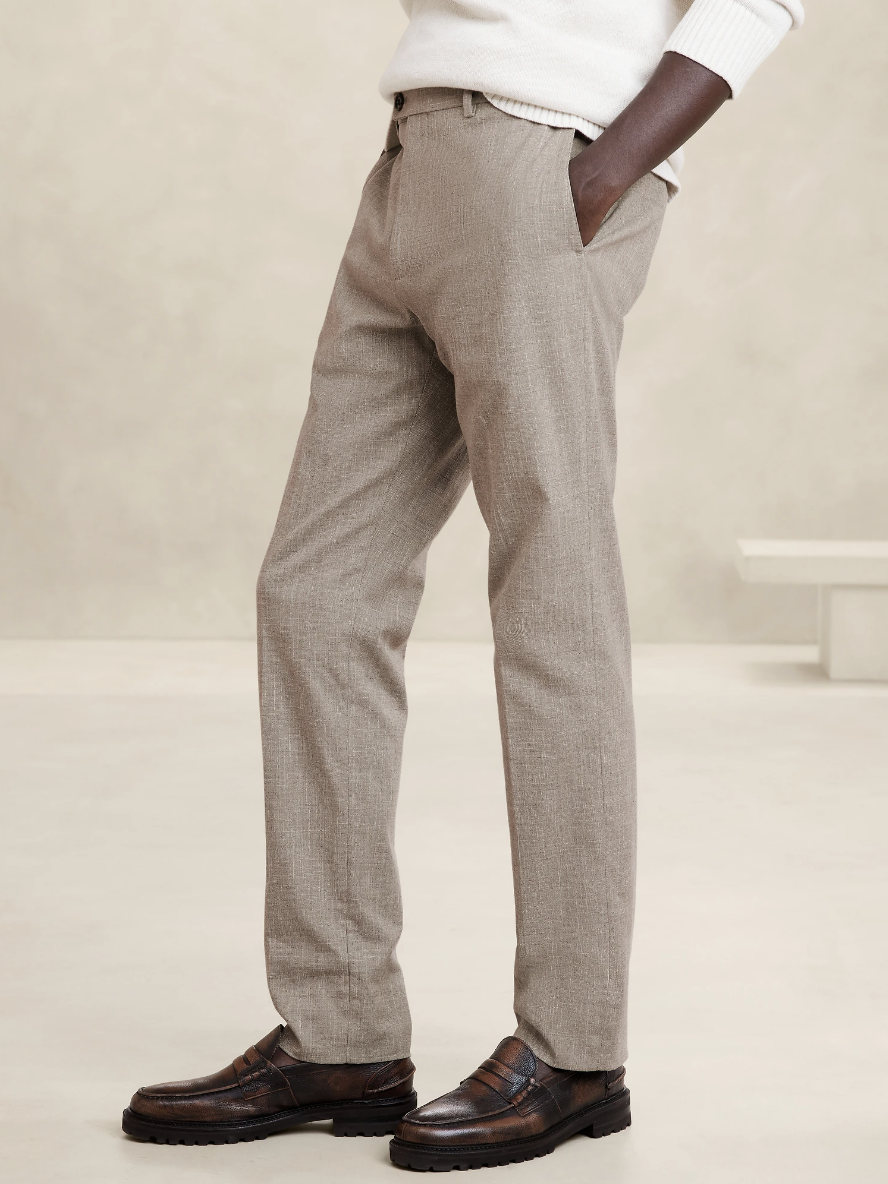

In [23]:
Image(filename='./images/best_practices/officer_example.png') 

In [24]:
with open("./images/best_practices/wrinkle.png", "rb") as f:
    wrinkle = f.read()
    
with open("./images/best_practices/officer.png", "rb") as f:
    officer = f.read()
    
with open("./images/best_practices/chinos.png", "rb") as f:
    chinos = f.read()
with open("./images/best_practices/officer_example.png", "rb") as f:
    officer_example = f.read()

In [25]:
messages = [
    {
        "role": 'user',
        "content": [
            {"image": {"format": 'png',"source": {"bytes": wrinkle}},},
            {"image": {"format": 'png',"source": {"bytes": officer}},},
            {"image": {"format": 'png',"source": {"bytes": chinos}},},
            {"image": {"format": 'png',"source": {"bytes": officer_example}},},
            {"text": "These pants are (in order) WRINKLE-RESISTANT DRESS PANT, ITALIAN MELTON OFFICER PANT, SLIM RAPID MOVEMENT CHINO. What pant is shown in the last image?"},
        ]
    }
]

converse_api_params = {
    "modelId": modelId,
    "messages": messages,
}
response = bedrock_client.converse(**converse_api_params)

# Extract the generated text content from the response
print(response['output']['message']['content'][0]['text'])

Based on the styling and texture visible in the last image, that appears to be the ITALIAN MELTON OFFICER PANT in the light gray/beige colorway. This can be seen from the textured fabric finish characteristic of melton wool, and it matches the flat-lay product shot shown in the second image. The pants are styled with brown leather loafers and a white top in the lifestyle photo.
